# VAE Model

Train the variational auto-encoder to mimic Phoenix temperature data.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

from helper_functions import *

In [2]:
# define constants
INPUT_SIZE = 64*24 # dimensions of the input data
DEGREE = 3 # degree of fourier series for seasonal inputs
LATENT_SIZE = 4*24 # the hours associated with each latent variable

## Read Training Data

See `process_data.ipynb` for the preparation of input data.

In [3]:
data = pd.read_csv('data/processed/phoenix_64days.csv', index_col=0, parse_dates=True)
data

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
1975-07-31,0.964283,0.758682,0.677235,0.667352,0.664610,0.607691,0.600477,0.801750,1.029786,1.009659,...,1.320080,1.315175,1.319647,1.315680,1.320585,0.886659,0.720375,0.695270,0.405120,0.365732
2017-08-19,0.703717,0.624205,0.521373,0.234700,0.337318,0.317850,0.227569,0.316138,0.638538,0.848409,...,0.345234,0.439151,0.485718,0.474878,0.369622,0.182857,0.012565,-0.023234,-0.123142,-0.315327
2001-07-06,0.839117,0.792497,0.617997,0.504204,0.451051,0.428592,0.352912,0.317114,0.430974,0.341955,...,1.397530,1.493560,1.484917,1.475048,1.471033,1.442517,0.777592,0.770106,0.652979,0.604590
2010-08-16,1.240002,1.121574,0.926427,0.802889,0.745228,0.727412,0.694128,0.678177,0.874774,0.905918,...,0.542830,0.585644,0.596969,0.592411,0.527708,0.450505,0.173873,0.086105,0.030448,-0.082456
1987-02-22,-1.260056,-1.367588,-1.481018,-1.603712,-1.679799,-1.740936,-1.751113,-1.717562,-1.681764,-1.422338,...,1.220573,1.273707,1.275041,1.271531,1.321508,1.103985,0.782790,0.710072,0.526452,0.478230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-11,-1.041151,-1.114603,-1.207998,-1.491556,-1.553934,-1.626629,-1.624703,-1.664318,-1.511225,-1.323540,...,-0.347897,-0.262600,-0.278471,-0.271025,-0.301563,-0.449291,-0.787470,-0.864418,-0.977245,-1.024708
1986-06-11,0.594550,0.479838,0.578058,0.037281,0.049013,0.052298,0.092726,0.322419,0.608160,0.908048,...,1.630983,1.819980,1.831177,1.671009,1.470882,1.320167,1.211221,1.204450,1.112331,1.030068
1992-07-29,0.912226,0.799497,0.679402,0.623579,0.602223,0.649598,0.627093,0.768274,0.969063,1.039755,...,1.437210,1.436331,1.436737,1.391794,1.193303,0.664128,0.388931,0.401096,0.255995,0.245182
2021-04-24,-0.149637,-0.277243,-0.380983,-0.462618,-0.562222,-0.645824,-0.717425,-0.609413,-0.270531,0.006312,...,1.681876,1.736526,1.729271,1.759037,1.746629,1.683300,1.499417,1.391677,1.277088,1.138498


### Create Seasonality Data

Calculate sines and cosines of earth's angle around the sun. This will be used as predictive data toward the latent prior in the form of a fourier series.

In [4]:
fourier = lambda x: np.stack([np.sin(2*np.pi*i*x) for i in range(1, DEGREE+1)] + [np.cos(2*np.pi*i*x) for i in range(1, DEGREE+1)], axis=-1)

In [5]:
starting_day = np.array(data.index.dayofyear)[:, np.newaxis] - 1
data_days = (starting_day + np.arange(0, INPUT_SIZE//24, LATENT_SIZE//24)) % 365
seasonal_data = fourier(data_days/365)
seasonal_data.shape

(285, 16, 6)

Separate training and testing data

In [6]:
training_ratio = 0.8

train = data.values[:int(len(data)*training_ratio)]
test = data.values[int(len(data)*training_ratio):]
train_seasonal = seasonal_data[:int(len(data)*training_ratio)]
test_seasonal = seasonal_data[int(len(data)*training_ratio):]

# convert to tensors
train_tensor = tf.convert_to_tensor(train, dtype=tf.float32)
test_tensor = tf.convert_to_tensor(test, dtype=tf.float32)
train_seasonal_tensor = tf.convert_to_tensor(train_seasonal, dtype=tf.float32)
test_seasonal_tensor = tf.convert_to_tensor(test_seasonal, dtype=tf.float32)

## Define Model

In [7]:
# Parameters
input_shape = None #INPUT_SIZE
latent_dim = None #INPUT_SIZE//LATENT_SIZE
latent_filter = 10
interim_filters = 2*latent_filter

### Encoder

In [8]:
# Build the encoder
def build_encoder():
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Reshape((-1, 1))(inputs)
    x = layers.Conv1D(interim_filters, 5, strides=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1D(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1D(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1D(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1D(2*latent_filter, 3, strides=2, padding='same')(x)
    z_mean = x[: ,:, :latent_filter]
    z_log_var = x[:, :, latent_filter:]
    z = Sampling()([z_mean, z_log_var])
    encoder = models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    return encoder

encoder = build_encoder()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, None, 1)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 20)  │        120 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, None, 20)  │      1,220 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, None, 20)  │      1,220 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, None, 20)  │      1,220 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, None, 20)  │      1,220 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, None, 20)  │      1,220 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, None, 10)  │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, None, 10)  │          0 │ conv1d_5[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, None, 10)  │          0 │ get_item[0][0],   │
│                     │                   │            │ get_item_1[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,220 (24.30 KB)

 Trainable params: 6,220 (24.30 KB)

 Non-trainable params: 0 (0.00 B)

### Decoder

In [9]:
# Build the decoder
def build_decoder():
    latent_inputs = layers.Input(shape=(latent_dim, latent_filter))
    x = layers.Conv1DTranspose(interim_filters, 3, strides=2, padding='same', activation='relu')(latent_inputs)
    x = layers.Conv1DTranspose(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(1, 5, strides=3, padding='same')(x)
    outputs = layers.Reshape((-1,))(x)
    decoder = models.Model(latent_inputs, outputs, name='decoder')
    decoder.summary()
    return decoder

decoder = build_decoder()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, None, 20)       │           620 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, None, 20)       │         1,220 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, None, 20)       │         1,220 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, None, 20)       │         1,220 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, None, 20)       │         1,220 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, None, 1)        │           101 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, None)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,601 (21.88 KB)

 Trainable params: 5,601 (21.88 KB)

 Non-trainable params: 0 (0.00 B)

### Prior

In [10]:
def build_seasonal_prior():
    seasonal_inputs = layers.Input(shape=(latent_dim, 2*DEGREE,))
    x = layers.Dense(2*latent_filter, use_bias=False)(seasonal_inputs)
    z_mean = x[:, :, :latent_filter]
    z_log_var = x[:, :, latent_filter:]
    z = Sampling()([z_mean, z_log_var])
    seasonal_prior = models.Model(seasonal_inputs, [z_mean, z_log_var, z], name='seasonal_prior')
    seasonal_prior.summary()
    return seasonal_prior

seasonal_prior = build_seasonal_prior()

Model: "seasonal_prior"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None, 6)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 20)  │        120 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, None, 10)  │          0 │ dense[0][0]       │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, None, 10)  │          0 │ dense[0][0]       │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, None, 10)  │          0 │ get_item_2[0][0], │
│ (Sampling)          │                   │            │ get_item_3[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 120 (480.00 B)

 Trainable params: 120 (480.00 B)

 Non-trainable params: 0 (0.00 B)

### Overall Model

In [11]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, prior, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior
        self.noise_log_var = self.add_weight(name='var', shape=(1,), initializer='zeros', trainable=True)

    @tf.function
    def vae_loss(self, data):
        values, seasonal = data
        z_mean, z_log_var, z = self.encoder(values)
        reconstructed = self.decoder(z)
        reconstruction_loss = -log_lik_normal_sum(values, reconstructed, self.noise_log_var)/INPUT_SIZE
        seasonal_z_mean, seasonal_z_log_var, _ = self.prior(seasonal)
        kl_loss_z = kl_divergence_sum(z_mean, z_log_var, seasonal_z_mean, seasonal_z_log_var)/INPUT_SIZE
        return reconstruction_loss, kl_loss_z

    def train_step(self, data):
        with tf.GradientTape() as tape:
            reconstruction_loss, kl_loss_z = self.vae_loss(data)
            total_loss = reconstruction_loss + kl_loss_z
        
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        return {'loss': total_loss}
    
    def test_step(self, data):
        reconstruction_loss, kl_loss_z = self.vae_loss(data)

        return {'loss': reconstruction_loss + kl_loss_z, 'recon': reconstruction_loss, 'kl': kl_loss_z}

    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

vae = VAE(encoder=encoder, decoder=decoder, prior=seasonal_prior)

## Train Model

In [14]:
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

vae.compile(optimizer=optimizer)

In [17]:
epochs = 100

batch_size = 32

history = vae.fit(
    train_tensor, train_seasonal_tensor, 
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_tensor, test_seasonal_tensor),
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.6181 - val_kl: 0.1395 - val_loss: -0.6542 - val_recon: -0.7937
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.6052 - val_kl: 0.1405 - val_loss: -0.6630 - val_recon: -0.8035
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.6056 - val_kl: 0.1413 - val_loss: -0.6607 - val_recon: -0.8021
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.6116 - val_kl: 0.1402 - val_loss: -0.6638 - val_recon: -0.8041
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.6079 - val_kl: 0.1411 - val_loss: -0.6593 - val_recon: -0.8004
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.6132 - val_kl: 0.1411 - val_loss: -0.6601 - val_recon: -0.8011
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.6116 - val_kl: 0.1413 - val_loss: -0.6612 - val_recon: -0.8025
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.6104 - val_kl: 0.1412 - val_loss: -0.6656 - val_recon: -0.8068
Epoch 9/

## Model Results

In [18]:
# Model reconstruction accuracy
print('noise emission sigma: ', np.exp(0.5*vae.noise_log_var)[0])

noise emission sigma:  0.102324024


In [19]:
# Loss on validation data

recon_loss, kl_loss = vae.vae_loss((test_tensor, test_seasonal_tensor))
recon_loss = recon_loss.numpy()
kl_loss = kl_loss.numpy()
total_loss = recon_loss + kl_loss

print('Reconstruction loss: ', recon_loss)
print('KL loss:             ', kl_loss)
print('Total loss:          ', total_loss)

Reconstruction loss:  -0.8494765
KL loss:              0.14912993
Total loss:           -0.7003466


Review latent variables

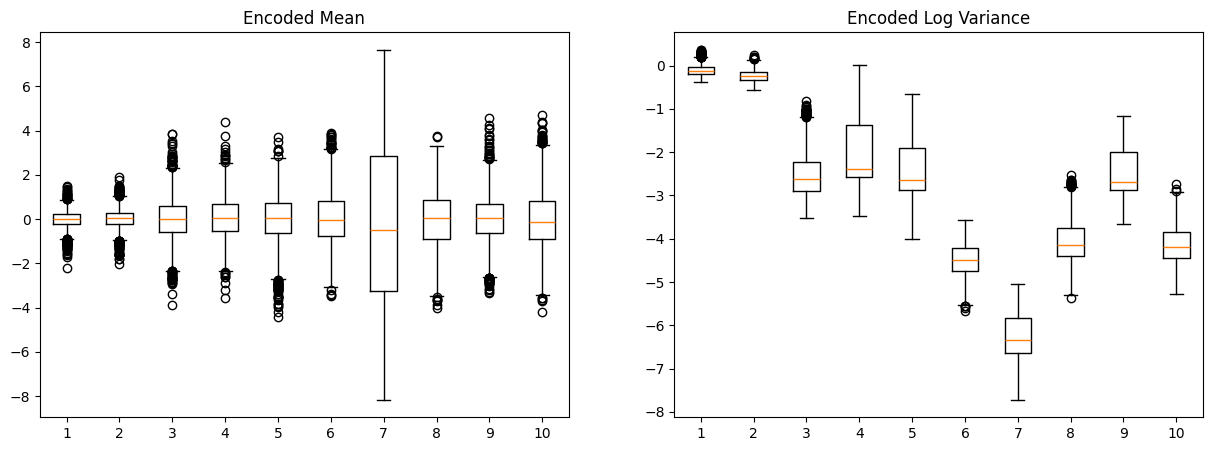

In [20]:
encoded_mean, encoded_log_var, encoded_z = encoder(train_tensor)

# set figure size
plt.figure(figsize=(15, 5))
# boxplot of encoded_mean
plt.subplot(1, 2, 1)
plt.boxplot(encoded_mean.numpy().reshape(-1, latent_filter))
plt.title('Encoded Mean')

# boxplot of encoded_log_var
plt.subplot(1, 2, 2)
plt.boxplot(encoded_log_var.numpy().reshape(-1, latent_filter))
plt.title('Encoded Log Variance')

plt.show()

## Generate Data

Use the trained model to generate new time series data

In [29]:
start_date = '1974-01-01'
end_date = '2023-12-31 23:00:00'
dt = pd.date_range(start=start_date, end=end_date, freq='h')

gen_seasonal_inputs = fourier((dt.dayofyear[::4*24]-1)/365)[np.newaxis]
gen_seasonal_inputs.shape

(1, 4566, 6)

In [31]:
_, _, z_gen = seasonal_prior(gen_seasonal_inputs)
z_gen.shape

TensorShape([1, 4566, 10])

In [39]:
gen_mean = decoder(z_gen).numpy()
noise = np.random.normal(size=gen_mean.shape)*np.exp(0.5*vae.noise_log_var[0].numpy())
gen = gen_mean #+ noise
gen.shape

(1, 438336)

In [40]:
gen_series = pd.Series(gen[0, :len(dt)]*18.29 + 75.08, index=dt)
gen_series

1974-01-01 00:00:00    40.482704
1974-01-01 01:00:00    38.221806
1974-01-01 02:00:00    36.132202
1974-01-01 03:00:00    32.789696
1974-01-01 04:00:00    31.906300
                         ...    
2023-12-31 19:00:00    64.512405
2023-12-31 20:00:00    58.124634
2023-12-31 21:00:00    56.781807
2023-12-31 22:00:00    54.241039
2023-12-31 23:00:00    52.967545
Freq: h, Length: 438288, dtype: float32

In [41]:
gen_series.to_csv('data/processed/generated.csv')